<a href="https://colab.research.google.com/github/peterpotros71/Speech_Emotion_Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
#librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
# to play the audio files
from IPython.display import Audio
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay, f1_score
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The EMODB database comprises of seven emotions: 1) anger; 2) boredom; 3) fear; 4) happiness; 5) sadness; 6) disgust; and 7) neutral. The data was recorded at a 48-kHz sampling rate and then down-sampled to 16-kHz.

Every utterance is named according to the same scheme:<br>
* Speaker [0:2]. 
* Text Code [2:5].
* Emotion [5] => (W = anger, L = boredom, A = fear, F = happiness, T = sadness, E = disgust, N = neutral).
* Version [6].

Example: 03a01Fa.wav is the audio file from Speaker 03 speaking text a01 with the emotion "Freude" (Happiness).

In [ ]:
speaker = []
text_code = []
emotion = []
version = []
file_path = []
audio_arrays = []

for file in tqdm(glob('/content/drive/MyDrive/emotions/wav/*')):
    file_path.append(file)
    file_name = os.path.split(file)[-1][:-4]
    speaker.append(file_name[0:2])
    text_code.append(file_name[2:5])
    emotion.append(file_name[5])
    version.append(file_name[6])
    data, sr = librosa.load(file, sr=44100)
    audio_arrays.append(data)

100%|██████████| 535/535 [01:15<00:00,  7.10it/s]


## Prepare Dataframe

In [ ]:
metadata_df = pd.DataFrame({'speaker': speaker, 'text_code': text_code, 'emotion': emotion, 'version': version, 'path':file_path, 'audio_arrays':audio_arrays})
metadata_df.head()

,speaker,text_code,emotion,version,path,audio_arrays
0,03,a02,T,a,/content/drive/MyDrive/emotions/wav/03a02Ta.wav,"[-1.9172372e-05, -5.7831174e-05, -3.9918894e-0..."
1,03,a01,F,a,/content/drive/MyDrive/emotions/wav/03a01Fa.wav,"[0.00072178146, 0.0015636807, 0.0024770123, 0...."
2,03,a02,F,c,/content/drive/MyDrive/emotions/wav/03a02Fc.wav,"[0.0006528445, 0.0012061528, 0.001965395, 0.00..."
3,03,a01,W,a,/content/drive/MyDrive/emotions/wav/03a01Wa.wav,"[1.1986539e-05, 4.669872e-05, 4.891362e-05, 3...."
4,03,a02,W,b,/content/drive/MyDrive/emotions/wav/03a02Wb.wav,"[0.0025674475, 0.0029938712, 0.003159917, 0.00..."


In [ ]:
metadata_df.emotion.unique()

array(['T', 'F', 'W', 'N', 'E', 'L', 'A'], dtype=object)

In [ ]:
# replace emotion symbols wuth normal words
metadata_df.emotion.replace({'N':'neutral', 'F':'happy', 'T':'sad', 'W':'angry', 'A':'fear', 'E':'disgust', 'L':'boredom'}, inplace=True)
metadata_df.head()

,speaker,text_code,emotion,version,path,audio_arrays
0,03,a02,sad,a,/content/drive/MyDrive/emotions/wav/03a02Ta.wav,"[-1.9172372e-05, -5.7831174e-05, -3.9918894e-0..."
1,03,a01,happy,a,/content/drive/MyDrive/emotions/wav/03a01Fa.wav,"[0.00072178146, 0.0015636807, 0.0024770123, 0...."
2,03,a02,happy,c,/content/drive/MyDrive/emotions/wav/03a02Fc.wav,"[0.0006528445, 0.0012061528, 0.001965395, 0.00..."
3,03,a01,angry,a,/content/drive/MyDrive/emotions/wav/03a01Wa.wav,"[1.1986539e-05, 4.669872e-05, 4.891362e-05, 3...."
4,03,a02,angry,b,/content/drive/MyDrive/emotions/wav/03a02Wb.wav,"[0.0025674475, 0.0029938712, 0.003159917, 0.00..."


## Data Visualisation and Exploration

#####  First let's plot the count of each emotions in our dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


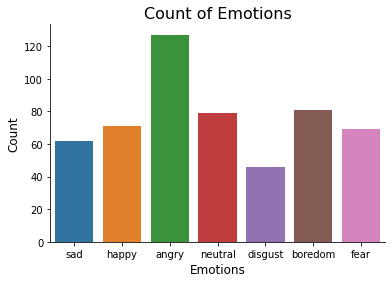

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(metadata_df.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals
​
* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

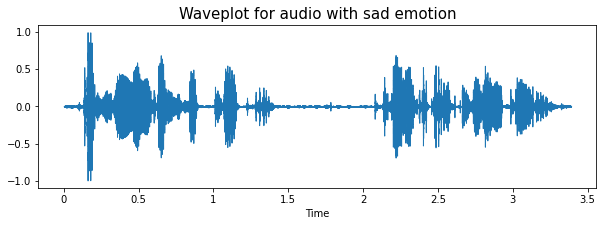

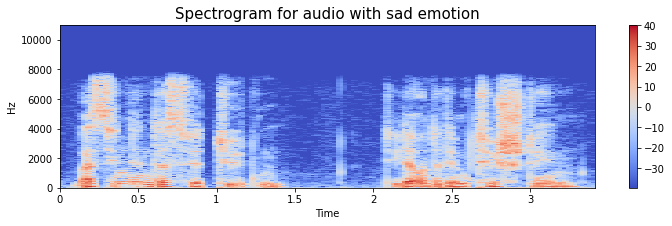

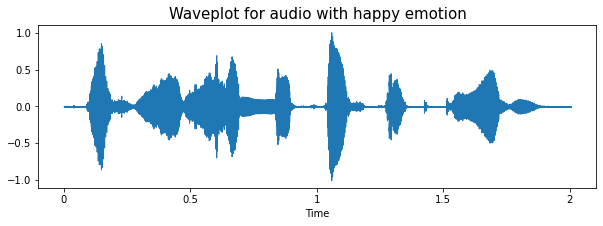

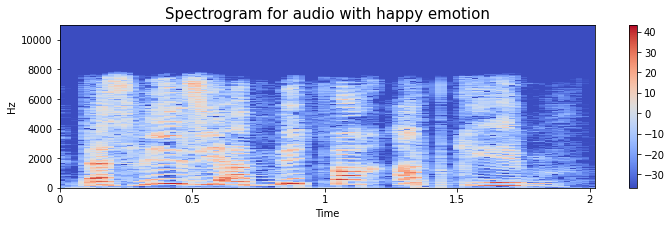

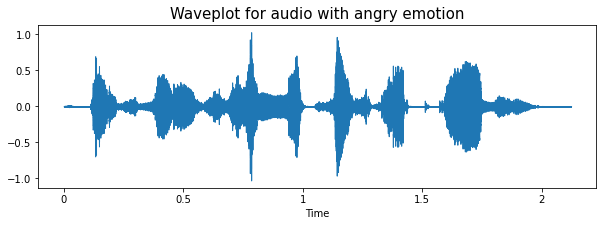

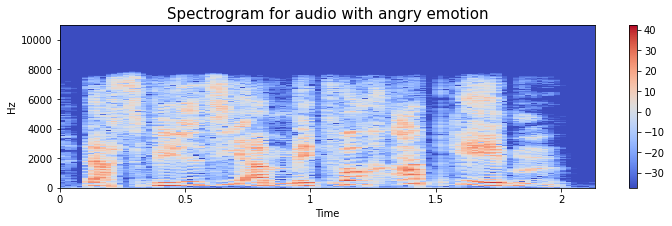

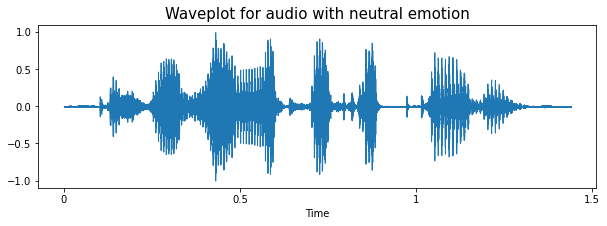

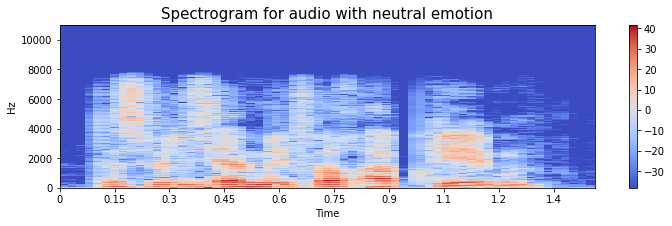

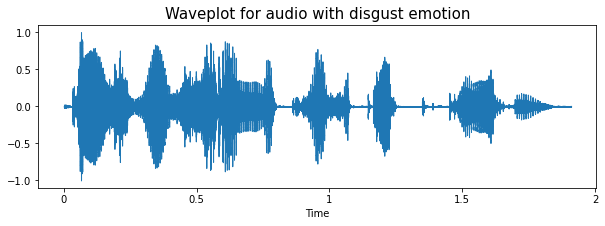

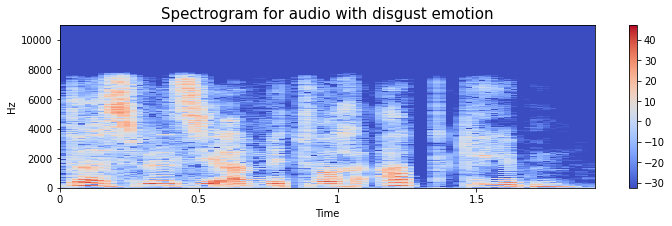

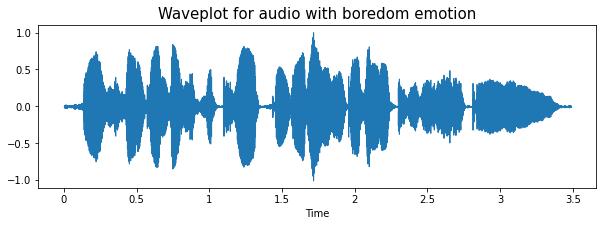

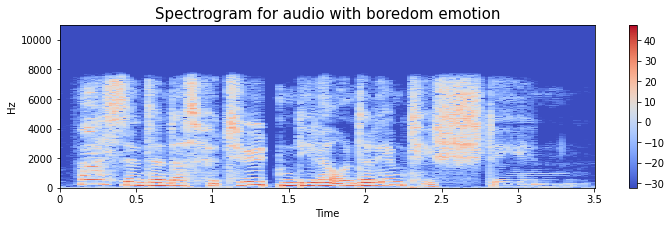

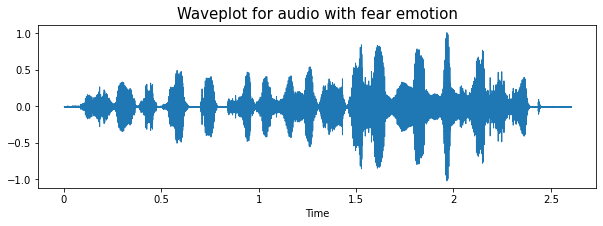

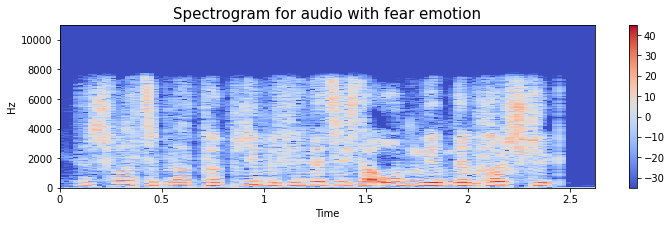

In [ ]:
for emotion in metadata_df.emotion.unique():
    path = np.array(metadata_df.path[metadata_df.emotion==emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(path))

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(metadata_df.path)[0]
data, sample_rate = librosa.load(path)
len(data)

38272

#### 1. Simple Audio

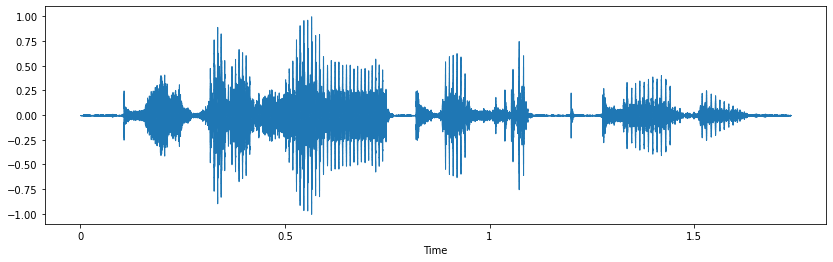

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

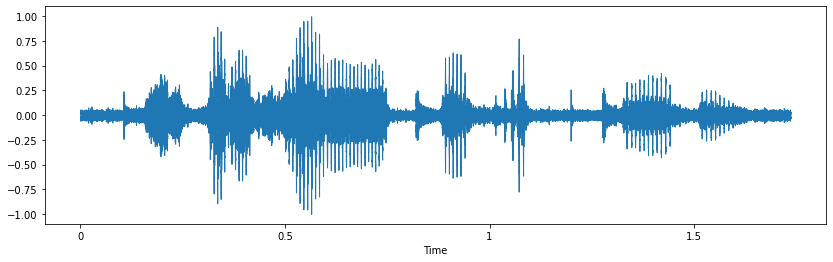

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

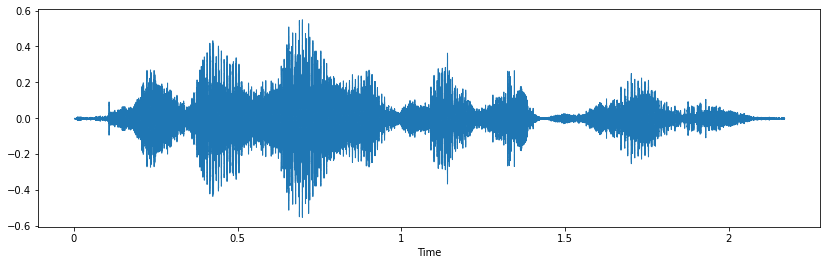

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

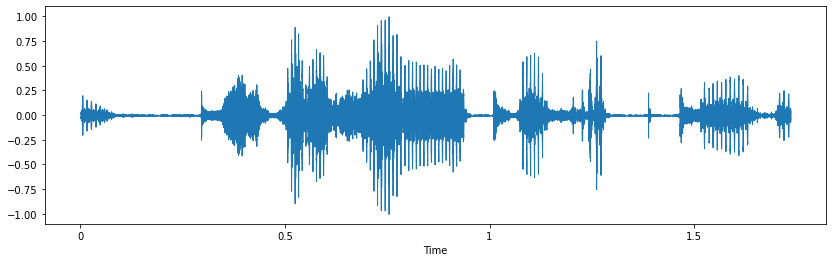

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

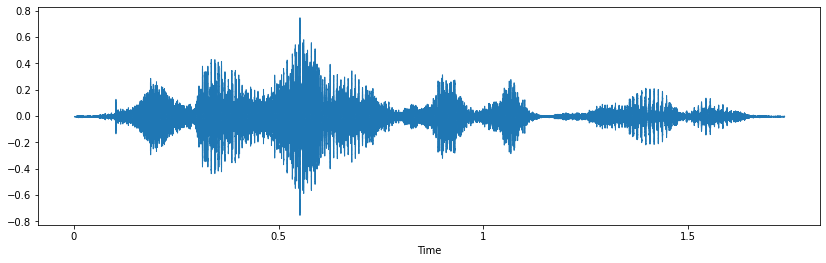

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

We can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [ ]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [ ]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching 
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    # data with pitching
    pitch_data = pitch(data, sample_rate)
    res4 = extract_features(pitch_data, sample_rate)
    result = np.vstack((result, res4)) # stacking vertically
    
    # data with shifting
    shift_data = shift(data)
    res5 = extract_features(shift_data, sample_rate)
    result = np.vstack((result, res5)) # stacking vertically
    
    return result

In [ ]:
get_features(path).shape

(5, 162)

In [ ]:
X, Y = [], []
for path, emotion in tqdm(zip(metadata_df.path, metadata_df.emotion)):
    features = get_features(path)
    for feature in features:
        X.append(feature)
        # appending emotion 5 times as we have made 5 augmentation techniques on each audio file.
        Y.append(emotion)   

535it [04:58,  1.79it/s]


In [ ]:
len(X), len(Y), metadata_df.path.shape

(2675, 2675, (535,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.058873,0.572746,0.636015,0.648951,0.698066,0.755364,0.745043,0.756426,0.758739,0.667212,...,1.118236e-06,1.037875e-06,9.734835e-07,9.202009e-07,8.767870e-07,8.426715e-07,8.162191e-07,7.977849e-07,7.862569e-07,sad
1,0.251086,0.717937,0.744277,0.756132,0.817188,0.838066,0.741478,0.736808,0.723948,0.720979,...,2.467179e-02,2.314994e-02,2.567141e-02,2.411313e-02,2.395027e-02,2.337282e-02,2.323047e-02,2.471859e-02,2.419497e-02,sad
2,0.072155,0.567211,0.607509,0.614207,0.680641,0.738227,0.689635,0.728914,0.709373,0.623391,...,9.453753e-07,8.774582e-07,8.230348e-07,7.780076e-07,7.413237e-07,7.124903e-07,6.901415e-07,6.745565e-07,6.648213e-07,sad
3,0.076421,0.522950,0.597854,0.615331,0.646423,0.748682,0.698895,0.735652,0.742784,0.649453,...,1.449204e-06,1.352064e-06,1.287166e-06,1.240670e-06,1.225552e-06,1.284501e-06,1.743045e-06,2.989946e-06,4.053144e-06,sad
4,0.058962,0.585656,0.659563,0.665706,0.712500,0.768155,0.744288,0.753720,0.761654,0.663641,...,2.604867e-06,2.414076e-06,2.268967e-06,2.153433e-06,2.061564e-06,1.990921e-06,1.936787e-06,1.899545e-06,1.876133e-06,sad


In [ ]:
Features.shape

(2675, 163)

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

1. splitting data to traing sets: X_train, y_train & testing sets: X_test, *y_test*

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2140, 162), (2140,), (535, 162), (535,))

2. scaling our data with sklearn's Standard scaler to bound values between 0 and 1

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2140, 162), (2140,), (535, 162), (535,))

## Modelling

### 1-LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
y_pred_lr = lr.predict(X_test)
print("Training set score: {:.3f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr.score(X_test, y_test)))
print(classification_report(y_test,y_pred_lr))

Training set score: 0.958
Test set score: 0.850
              precision    recall  f1-score   support

       angry       0.88      0.90      0.89       134
     boredom       0.80      0.87      0.84        70
     disgust       0.72      0.79      0.76        39
        fear       0.86      0.82      0.84        77
       happy       0.83      0.75      0.79        65
     neutral       0.86      0.86      0.86        91
         sad       0.93      0.90      0.91        59

    accuracy                           0.85       535
   macro avg       0.84      0.84      0.84       535
weighted avg       0.85      0.85      0.85       535



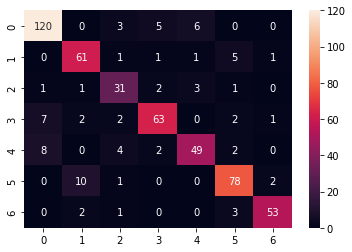

In [ ]:
cm_lr= pd.DataFrame(confusion_matrix(y_test,y_pred_lr))
sns.heatmap(cm_lr, annot = True, fmt = 'g');

### 2-RandomForestClassifier

In [ ]:
grid = {'n_estimators': [10, 50, 100, 200,300]}
rf= GridSearchCV(RandomForestClassifier(),grid)
rf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [10, 50, 100, 200, 300]})

In [ ]:
y_pred_rf= rf.predict(X_test)
print("Training set score: {:.3f}".format(rf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(rf.score(X_test, y_test)))
print(classification_report(y_test,y_pred_rf))

Training set score: 1.000
Test set score: 0.920
              precision    recall  f1-score   support

       angry       0.93      0.99      0.96       134
     boredom       0.90      0.93      0.92        70
     disgust       0.94      0.87      0.91        39
        fear       0.92      0.87      0.89        77
       happy       0.88      0.82      0.85        65
     neutral       0.89      0.90      0.90        91
         sad       0.98      1.00      0.99        59

    accuracy                           0.92       535
   macro avg       0.92      0.91      0.92       535
weighted avg       0.92      0.92      0.92       535



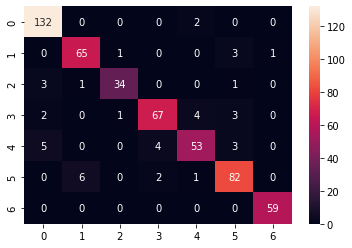

In [ ]:
cm_rf = pd.DataFrame(confusion_matrix(y_test,y_pred_rf))
sns.heatmap(cm_rf, annot = True, fmt = 'g');

### 3-Support Vector (SVM)

In [ ]:
grid = {'C': [1, 5, 50], 'gamma': [0.05, 0.1, 0.5, 1, 5]}
svc_clf = GridSearchCV(SVC(),grid)
svc_clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 5, 50], 'gamma': [0.05, 0.1, 0.5, 1, 5]})

In [ ]:
y_pred_svc = svc_clf.predict(X_test)
print("Training set score: {:.3f}".format(svc_clf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(svc_clf.score(X_test, y_test)))
print(classification_report(y_test,y_pred_svc))

Training set score: 1.000
Test set score: 0.778
              precision    recall  f1-score   support

       angry       0.56      0.99      0.72       134
     boredom       0.94      0.73      0.82        70
     disgust       0.94      0.85      0.89        39
        fear       0.98      0.66      0.79        77
       happy       0.95      0.63      0.76        65
     neutral       0.91      0.80      0.85        91
         sad       0.97      0.59      0.74        59

    accuracy                           0.78       535
   macro avg       0.90      0.75      0.80       535
weighted avg       0.85      0.78      0.78       535



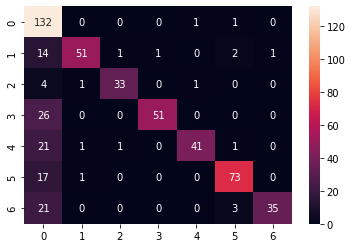

In [ ]:
cm_scv= pd.DataFrame(confusion_matrix(y_test,y_pred_svc))
sns.heatmap(cm_scv, annot = True, fmt = 'g');

### 4-XGBoost Classifier

In [ ]:
xgb_clf = OneVsRestClassifier(xgb.XGBClassifier(n_jobs = -1))
xgb_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=XGBClassifier(n_jobs=-1))

In [ ]:
y_pred_xgb = xgb_clf.predict(X_test)
print("Training set score: {:.3f}".format(xgb_clf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(xgb_clf.score(X_test, y_test)))
print(classification_report(y_test,y_pred_xgb))

Training set score: 0.999
Test set score: 0.912
              precision    recall  f1-score   support

       angry       0.95      0.96      0.96       134
     boredom       0.86      0.90      0.88        70
     disgust       0.89      0.87      0.88        39
        fear       0.94      0.83      0.88        77
       happy       0.85      0.92      0.88        65
     neutral       0.90      0.87      0.88        91
         sad       0.97      1.00      0.98        59

    accuracy                           0.91       535
   macro avg       0.91      0.91      0.91       535
weighted avg       0.91      0.91      0.91       535



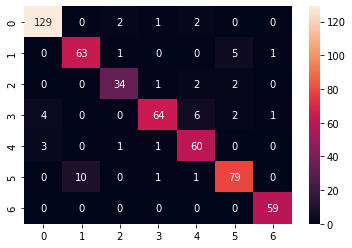

In [ ]:
cm_xgb = pd.DataFrame(confusion_matrix(y_test,y_pred_xgb))
sns.heatmap(cm_xgb, annot = True, fmt = 'g');

### 4-KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred_knn = knn_clf.predict(X_test)
print("Training set score: {:.3f}".format(knn_clf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(knn_clf.score(X_test, y_test)))

Training set score: 0.951
Test set score: 0.830


In [ ]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

       angry       0.90      0.84      0.87       134
     boredom       0.82      0.84      0.83        70
     disgust       0.73      0.82      0.77        39
        fear       0.85      0.81      0.83        77
       happy       0.73      0.80      0.76        65
     neutral       0.79      0.88      0.83        91
         sad       0.96      0.78      0.86        59

    accuracy                           0.83       535
   macro avg       0.83      0.82      0.82       535
weighted avg       0.84      0.83      0.83       535



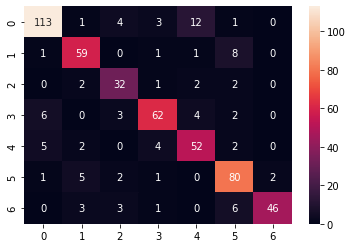

In [ ]:
cm_knn= pd.DataFrame(confusion_matrix(y_test,y_pred_knn))
sns.heatmap(cm_knn, annot = True, fmt = 'g');

- We can see our model is more accurate in predicting training set than testing set in most models so it suffers from overfitteing which can be solved by  applying more augmentation techniques and using more audio files.